# **Case -  Setorização e Priorização de Pontos de Venda para Vendedores**


# Introdução

A Gelarte, uma indústria de sorvetes em fase de expansão, deseja estabelecer sua presença na cidade de São Paulo.
 Para isso, contratou uma equipe de **8 vendedores** responsáveis pela prospecção de pontos de venda, ou seja, estabelecimentos comerciais que possam comercializar os produtos da marca.

Atualmente, a empresa identificou **2.250 potenciais pontos de venda** na cidade mas para garantir uma abordagem eficiente, é necessário selecionar e priorizar **50 PDVs para cada vendedor**, **totalizando 400 pontos distribuídos entre os 8 vendedores**. Essa distribuição precisa ser feita de maneira estratégica, levando em consideração fatores comerciais e logísticos.

**Objetivo do Projeto**

Este projeto tem como objetivo definir uma metodologia para a setorização e priorização dos pontos de venda, garantindo que cada vendedor tenha uma área de atuação bem distribuída e eficiente. Para isso, serão utilizados critérios comerciais e geográficos para definir os melhores pontos de prospecção.

**As principais etapas do projeto incluem:**

1. Filtragem inicial dos pontos de venda, garantindo que apenas estabelecimentos relevantes sejam considerados (estabelecimentos alimentícios).

2. Clusterização geográfica, utilizando técnicas de aprendizado de máquina para agrupar pontos de venda em 8 setores, um para cada vendedor.

3. Priorização dentro de cada setor, selecionando os 50 pontos de maior potencial de vendas para cada vendedor.

4. Visualização dos resultados, com mapas e gráficos que ilustram a distribuição final dos pontos de venda.


Com essa abordagem, garantimos que a equipe de vendas tenha um direcionamento estratégico, otimizando o tempo de deslocamento, aumentando a eficiência das visitas e maximizando o potencial de vendas da Gelarte na cidade de São Paulo.

# Dicíonário Da Base

A base de dados Base_prospeccao.xlsx contém informações sobre estabelecimentos comerciais que podem se tornar pontos de venda para a Gelarte.


 Abaixo está a descrição detalhada de cada variável presente na base:


•**ID:** Número identificador único de cada ponto de venda, utilizado para referência e controle dentro da base de dados.


• **Nome estabelecimento:** Nome comercial do estabelecimento, permitindo identificar o local de maneira clara.

• **Latitude e Longitude**: Coordenadas geográficas que indicam a localização exata do ponto de venda, fundamentais para a clusterização e análise geoespacial.

• **Categoria:** Tipo geral de estabelecimento, como “Restaurante”, “Mercado”, “Padaria e Cafeteria”, entre outros.

• **Categoria Detalhada:** Subcategoria mais específica dentro da categoria principal, trazendo maior granularidade sobre o tipo de comércio.

• **Probabilidade de Funcionamento**: Indicador qualitativo que classifica a chance do estabelecimento estar ativo, podendo assumir valores como “Muito alta”, “Alta”, “Média”, “Baixa” ou “Baixíssima”.

• **Faixa de Faturamento:** Estimativa do faturamento mensal do estabelecimento, segmentada em intervalos como “Até 81mil”, “Entre 81mil e 360mil” e “Maior que 10MM”.

• **Rede:** Nome da rede ou franquia à qual o estabelecimento pertence, caso faça parte de uma rede de lojas ou mercados.


Essas variáveis serão utilizadas para realizar a filtragem, setorização e priorização dos pontos de venda, garantindo que os vendedores tenham um direcionamento eficiente para a prospecção.



# 0.   Carregar a Base e importar as bibliotecas de manipulação e modelagem de dados


In [86]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN

In [87]:
#Caminho do arquivo aqui após subir no Colab
file_path = '/content/Base_prospeccao.xlsx'
#Verificar se o arquivo existe antes de carregar
import os
if os.path.exists(file_path):
   excel_data = pd.ExcelFile(file_path)
   print(excel_data.sheet_names)
   df = excel_data.parse('Plan1') #Nome da planilha
   display(df)
else:
   print(f"O arquivo {file_path} não foi encontrado.")

['Plan1']


,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede
0,118,LATICINIOS GUARANESIA ...,-23.51426,-46.58802,As 1-4 chks,Mercado,Muito alta,Entre R$81mil e R$360mil,...
1,128,MAGAZINE FOTO CUPECE ...,-23.67614,-46.64258,Papelaria,Papelaria,Baixíssima,Entre R$81mil e R$360mil,...
2,173,ADORA DOCES ...,-23.57103,-46.65806,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...
3,1110,RESTAURANTE AR LIVRE LTDA ...,-23.57356,-46.68943,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA ...
4,1119,OLIMAR ...,-23.53805,-46.59960,Bar e lanchonete,Lanchonete,Baixíssima,Entre R$81mil e R$360mil,...
...,...,...,...,...,...,...,...,...,...
2246,964152,CENTERSWEET COMERCIO DE DOCES LTDA ...,-23.60083,-46.66326,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...
2247,965100,KININHA CASA DE LANCHES LTDA ...,-23.50200,-46.62231,Bar e lanchonete,Lanchonete,Alta,Até R$81mil,...
2248,966134,PEDRO LUIZ RODRIGUES CENTENO ...,-23.53888,-46.49056,As 1-4 chks,Hortifruti,Muito alta,Entre R$81mil e R$360mil,...
2249,966148,CASA RAINHA PERNAMBUCANA COM DE PROD ALIM LTDA...,-23.66716,-46.65593,As 1-4 chks,Mercado,Muito alta,Entre R$81mil e R$360mil,CASA RAINHA PERNAMBUCANA COM DE PROD ALIM LTDA...


In [88]:
df.columns

Index(['ID', 'Nome estabelecimento', 'Latitude', 'Longitude', 'Categoria',
       'Categoria Detalhada', 'Probabilidade de Funcionamento',
       'Faixa de Faturamento', 'Rede'],
      dtype='object')



# 1.   Filtragem Inicial dos estabelecimentos do setor alimentício




In [89]:
#Importando a duckdb para algumas analises em SQL
import duckdb

query = """
  SELECT  "Categoria"
  FROM df
"""
result1 = duckdb.query(query).to_df()

display(result1)

,Categoria
0,As 1-4 chks
1,Papelaria
2,Padarias e cafeterias
3,Restaurante
4,Bar e lanchonete
...,...
2246,Padarias e cafeterias
2247,Bar e lanchonete
2248,As 1-4 chks
2249,As 1-4 chks


Quando lidamos com muitas categorias textuais, é necessário aplicar uma filtragem baseada em agrupamento semântico. Para isso, podemos utilizar técnicas de vetorização como TF-IDF, combinadas com algoritmos de clustering, como K-Means, para identificar grupos de textos semelhantes.

**Como funciona o TF-IDF?**

O TF-IDF (Term Frequency - Inverse Document Frequency) é uma técnica que transforma palavras em vetores numéricos, atribuindo pesos que indicam sua importância em um conjunto de textos. Ele mede a frequência da palavra em um documento, ajustando esse valor de acordo com sua raridade no conjunto de documentos.
 Dessa forma, palavras comuns têm menor peso, enquanto palavras mais específicas recebem um peso maior.
Após essa transformação cada documento passa a ser representado como um vetor de características numéricas permitindo comparações matemáticas entre textos.

**K-Means nesse exemplo:**

Após transformar as palavras em vetores com pesos, o K-means irá calcular a distâncias entre estes vetores usando a distância Euclidiana, e cada ponto (vetor) será atribuido a um Cluster, pontos com mais próximidade serão agrupados no mesmo cluster e os centroides são atualizados com a média dos pontos.



In [90]:
df["Categoria"] = df["Categoria"].str.strip()

df_clean = df.dropna(subset=["Categoria"])

#Remover espaços em branco à direita e a esquerda no df_clean

#Criar um vetor de palavras para as categorias
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df_clean["Categoria"])

#Definir o número de clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_clean["Cluster"] = kmeans.fit_predict(X)

#Criar um dicionário de clusters
clusters_dict = {}

for i in range(n_clusters):
   clusters_dict[f"Cluster {i}"] = df_clean[df_clean["Cluster"] == i]["Categoria"].unique()
#Exibir os clusters detectados
for cluster, categorias in clusters_dict.items():
   print(f"{cluster}: {categorias}\n")




# Remover espaços em branco à direita e à esquerda no df original


Cluster 0: ['As 1-4 chks' 'As 5-9 chks' 'As 10-19 chks']

Cluster 1: ['Restaurante']

Cluster 2: ['Padarias e cafeterias']

Cluster 3: ['Papelaria' 'Bar e lanchonete' 'Prédios' 'Cuidados com animais'
 'Farmácia' 'Atacadista' 'Automobilísticos' 'Variedades' 'Tabacaria'
 'Petróleo e derivados' 'Banca de jornais e revistas' 'Escritório'
 'Esportes' 'Alimentos' 'Associações' 'Não-alimentos' 'Transporte'
 'Indústria' 'Outros' 'Representantes comerciais' 'Profissionais'
 'Comunicação e tecnologia' 'Educação infantil' 'Manutenção' 'Tecnologia'
 'Especializados' 'Vestuário' 'Acomodação' 'Entretenimento'
 'Complexos esportivos']

Cluster 4: ['Beleza e bem-estar']

Cluster 5: ['Tradicional']

Cluster 6: ['Saúde']

Cluster 7: ['Eventos']

Cluster 8: ['Casa e construção' 'Construção civil']

Cluster 9: ['Perfumaria']



Vemos que a categoria "Bar e restaurante" Ficou dentro cluster muito generico mas ela percence a categoria alimentícia.

In [91]:
#Criar um dicionário de mapeamento de categorias para clusters
categoria_para_cluster = {}
for cluster, categorias in clusters_dict.items():
   for categoria in categorias:
       categoria_para_cluster[categoria] = cluster

#Criando uma nova coluna na base original para associando as categorias aos clusters
df["Cluster"] = df["Categoria"].map(categoria_para_cluster)
df["Categoria"] = df["Categoria"]

#Exibindo as primeiras linhas para verificar se a coluna foi add
display(df)

,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster
0,118,LATICINIOS GUARANESIA ...,-23.51426,-46.58802,As 1-4 chks,Mercado,Muito alta,Entre R$81mil e R$360mil,...,Cluster 0
1,128,MAGAZINE FOTO CUPECE ...,-23.67614,-46.64258,Papelaria,Papelaria,Baixíssima,Entre R$81mil e R$360mil,...,Cluster 3
2,173,ADORA DOCES ...,-23.57103,-46.65806,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2
3,1110,RESTAURANTE AR LIVRE LTDA ...,-23.57356,-46.68943,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA ...,Cluster 1
4,1119,OLIMAR ...,-23.53805,-46.59960,Bar e lanchonete,Lanchonete,Baixíssima,Entre R$81mil e R$360mil,...,Cluster 3
...,...,...,...,...,...,...,...,...,...,...
2246,964152,CENTERSWEET COMERCIO DE DOCES LTDA ...,-23.60083,-46.66326,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2
2247,965100,KININHA CASA DE LANCHES LTDA ...,-23.50200,-46.62231,Bar e lanchonete,Lanchonete,Alta,Até R$81mil,...,Cluster 3
2248,966134,PEDRO LUIZ RODRIGUES CENTENO ...,-23.53888,-46.49056,As 1-4 chks,Hortifruti,Muito alta,Entre R$81mil e R$360mil,...,Cluster 0
2249,966148,CASA RAINHA PERNAMBUCANA COM DE PROD ALIM LTDA...,-23.66716,-46.65593,As 1-4 chks,Mercado,Muito alta,Entre R$81mil e R$360mil,CASA RAINHA PERNAMBUCANA COM DE PROD ALIM LTDA...,Cluster 0


In [92]:
#movendo registros de alimentos do Cluster 3 para o Cluster 10
categorias_mover = ["Bar e lanchonete", "Alimentos", "Atacadista"]
df.loc[(df["Cluster"] == "Cluster 3") & (df["Categoria"].isin(categorias_mover)), "Cluster"] = "Cluster 10"

#Exibir os clusters após a movimentação
clusters_dict = {}
for cluster in df["Cluster"].unique():
   clusters_dict[f"{cluster}"] = df[df["Cluster"] == cluster]["Categoria"].unique()
#Exibir os clusters atualizados
for cluster, categorias in clusters_dict.items():
   print(f"{cluster}: {categorias}\n")

Cluster 0: ['As 1-4 chks' 'As 5-9 chks' 'As 10-19 chks']

Cluster 3: ['Papelaria' 'Prédios' 'Cuidados com animais' 'Farmácia'
 'Automobilísticos' 'Variedades' 'Tabacaria' 'Petróleo e derivados'
 'Banca de jornais e revistas' 'Escritório' 'Esportes' 'Associações'
 'Não-alimentos' 'Transporte' 'Indústria' 'Outros'
 'Representantes comerciais' 'Profissionais' 'Comunicação e tecnologia'
 'Educação infantil' 'Manutenção' 'Tecnologia' 'Especializados'
 'Vestuário' 'Acomodação' 'Entretenimento' 'Complexos esportivos']

Cluster 2: ['Padarias e cafeterias']

Cluster 1: ['Restaurante']

Cluster 10: ['Bar e lanchonete' 'Atacadista' 'Alimentos']

Cluster 5: ['Tradicional']

Cluster 8: ['Casa e construção' 'Construção civil']

Cluster 6: ['Saúde']

Cluster 4: ['Beleza e bem-estar']

Cluster 7: ['Eventos']

Cluster 9: ['Perfumaria']



In [93]:
# Filtrar o DataFrame pelos clusters 1, 2 e 10 (categorias alimentícias)
df_filtrado = df[df["Cluster"].isin(["Cluster 1", "Cluster 2", "Cluster 10"])]
display(df_filtrado)

,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster
2,173,ADORA DOCES ...,-23.571030,-46.658060,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2
3,1110,RESTAURANTE AR LIVRE LTDA ...,-23.573560,-46.689430,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA ...,Cluster 1
4,1119,OLIMAR ...,-23.538050,-46.599600,Bar e lanchonete,Lanchonete,Baixíssima,Entre R$81mil e R$360mil,...,Cluster 10
5,1170,MARSELHESA CAFE ...,-23.596620,-46.641340,Restaurante,Restaurante geral,Alta,Entre R$360mil e R$4.8MM,MARSELHESA CAFE LTDA ...,Cluster 1
6,2140,QUALITTA CAFE & RESTAURANTE ...,-23.524270,-46.644980,Restaurante,Restaurantes típicos,Média,Entre R$81mil e R$360mil,QUALITTA CAFE & RESTAURANTE LTDA ...,Cluster 1
...,...,...,...,...,...,...,...,...,...,...
2243,745511,NAKATA M EMPORIO LTDA ...,-23.502750,-46.625060,Bar e lanchonete,Lanchonete,Muito alta,Entre R$360mil e R$4.8MM,NAKATA M EMPORIO LTDA ...,Cluster 10
2244,962137,FAZENDINHA BRASIL ...,-23.569333,-46.644133,Restaurante,Restaurante geral,Muito alta,Entre R$81mil e R$360mil,RECHEATTI COMERCIO DE ALIMENTOS LTDA ...,Cluster 1
2245,963182,BOM DE CAFE COMERCIO LTDA ...,-23.618210,-46.671630,Padarias e cafeterias,Cafeteria,Média,Entre R$81mil e R$360mil,...,Cluster 2
2246,964152,CENTERSWEET COMERCIO DE DOCES LTDA ...,-23.600830,-46.663260,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2


**Visualização da distribuição original dos PDVs VS distribuição dos PDVs filtrando estabelecimentos alimentícios**

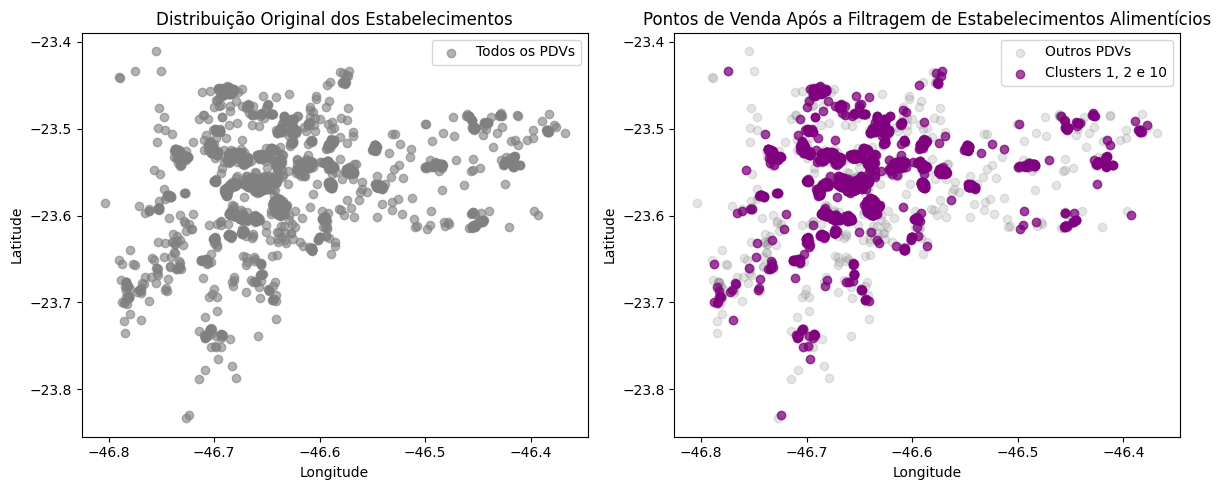

In [94]:
#Criar os gráficos para antes e depois
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Gráfico antes da filtragem (todas as categorias)
axes[0].scatter(df["Longitude"], df["Latitude"], c="gray", alpha=0.6, label="Todos os PDVs")
axes[0].set_title("Distribuição Original dos Estabelecimentos")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].legend()

#Gráfico após a filtragem (somente clusters 1, 2 e 10)
axes[1].scatter(df["Longitude"], df["Latitude"], c="gray", alpha=0.2, label="Outros PDVs")
axes[1].scatter(df_filtrado["Longitude"], df_filtrado["Latitude"], c="purple", alpha=0.7, label="Clusters 1, 2 e 10")
axes[1].set_title("Pontos de Venda Após a Filtragem de Estabelecimentos Alimentícios")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].legend()


#Exibindo os gráficos
plt.tight_layout()
plt.show()






# 2.   Clusterização geográfica, utilizando técnicas de aprendizado de máquina para agrupar pontos de venda em 8 setores, um para cada vendedor.

Durante a análise da clusterização geográfica dos pontos de venda (PDVs), testamos diferentes abordagens para agrupar os estabelecimentos de maneira eficiente, garantindo uma distribuição equitativa para os 8 vendedores. Inicialmente, utilizamos o K-Means, mas observamos que ele reduzia drasticamente o número de PDVs atribuídos aos clusters. Diante disso, optamos por utilizar o DBSCAN, um algoritmo baseado em densidade, que apresentou melhor desempenho para os nossos objetivos.

**Diferenças entre K-Means e DBSCAN**

A escolha do DBSCAN foi baseada nas diferenças de performance e funcionalidade entre os dois algoritmos:

**1-K-Means (Testado inicialmente)**
• O K-Means requer um número fixo de clusters (no nosso caso, 8), o que significa que ele força a divisão dos PDVs em grupos previamente definidos.

• Ele assume que os clusters têm formato esférico e tamanhos similares, o que pode ser problemático para dados geográficos distribuídos de maneira irregular.

• Durante os testes, o K-Means eliminou muitos PDVs porque alguns grupos ficaram muito pequenos ou não tinham pontos suficientemente próximos do centro do cluster.

**Problema encontrado:**

• **Após aplicar o K-Means, o número de PDVs caiu de 1097 para apenas 346, o que inviabilizou a distribuição entre os 8 vendedores.**

**2️ DBSCAN (Escolhido para a clusterização final)**

• Não exige um número fixo de clusters, identificando agrupamentos naturalmente com base na densidade dos pontos.

• Clusters podem ter tamanhos diferentes, o que faz mais sentido para dados geográficos, onde algumas regiões possuem maior concentração de PDVs do que outras.

• Não elimina pontos automaticamente; apenas classifica como “ruído” os que não pertencem a nenhum grupo permitindo um ajuste mais preciso.


<ipython-input-95-9d78d0c79718>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["Setor"] = dbscan.fit_predict(df_filtrado[["Latitude", "Longitude"]])


Total de PDVs após DBSCAN: 1437
Distribuição dos setores:
Setor
 0     566
 4     110
 1      88
 2      87
-1      57
 6      50
 15     36
 3      35
 5      34
 16     33
 19     32
 8      29
 10     28
 23     25
 14     23
 18     22
 20     22
 11     20
 25     15
 29     15
 12     11
 9      11
 28     11
 30      8
 31      8
 17      7
 21      7
 24      6
 26      6
 7       6
 13      5
 27      4
 22      4
 34      4
 32      4
 33      4
 35      4
Name: count, dtype: int64
Número de PDVs classificados como ruído: 57


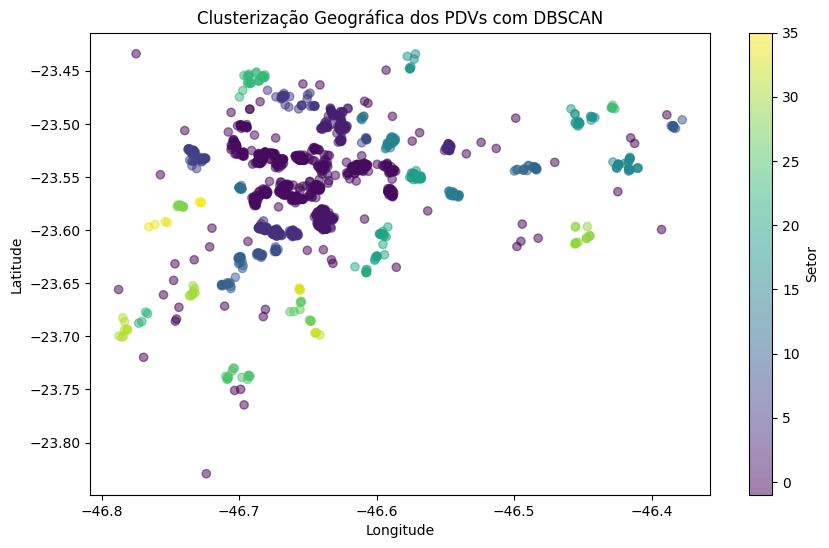

In [95]:
#definir os parâmetros do DBSCAN
eps = 0.01  # Distância máxima entre dois pontos para serem considerados do mesmo cluster
min_samples = 3  # Número mínimo de PDVs para formar um cluster

#Aplicar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_filtrado["Setor"] = dbscan.fit_predict(df_filtrado[["Latitude", "Longitude"]])

# Contar o número total de PDVs após a clusterização
print(f"Total de PDVs após DBSCAN: {df_filtrado.shape[0]}")
# Contar quantos setores foram criados
print(f"Distribuição dos setores:\n{df_filtrado['Setor'].value_counts()}")
# Contar quantos PDVs foram classificados como ruído (-1)
num_ruido = (df_filtrado["Setor"] == -1).sum()
print(f"Número de PDVs classificados como ruído: {num_ruido}")


#Visualizar os clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado["Longitude"], df_filtrado["Latitude"], c=df_filtrado["Setor"], cmap="viridis", alpha=0.5)
plt.colorbar(label="Setor")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusterização Geográfica dos PDVs com DBSCAN")
plt.show()



# 3.   Priorização dentro de cada setor, selecionando os 50 pontos de maior potencial de vendas para cada vendedor.




Após a clusterização inicial com DBSCAN, aplicaremos K-Means para consolidar os setores em 8 grupos, garantindo uma distribuição mais uniforme dos PDVs entre os vendedores.

• O DBSCAN já organizou os PDVs em grupos naturais, respeitando a densidade geográfica.

• Agora, o K-Means não precisa mais identificar setores do zero, apenas reagrupar os clusters do DBSCAN em 8 grupos fixos.

• Isso evita a perda de PDVs que acontecia quando aplicávamos K-Means diretamente já que o DBSCAN é mais flexivel preservando os agrupamentos naturais.



<ipython-input-96-9cee9b09eb27>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans["Setor_Final"] = kmeans_final.fit_predict(df_kmeans[["Latitude", "Longitude"]])


Setor_Final
1    353
5    275
7    177
3    168
6    125
0    114
2    107
4     61
Name: count, dtype: int64


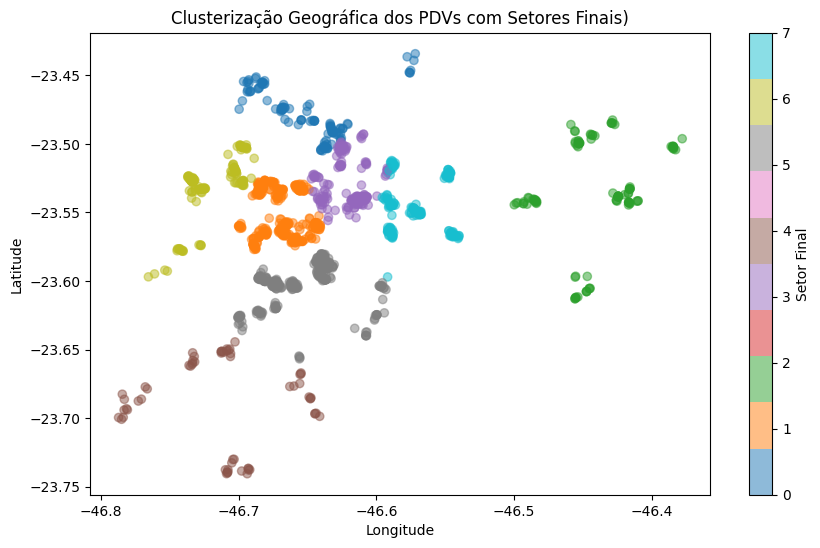

In [96]:
#Remover os PDVs classificados como ruído (-1) pelo DBSCAN
df_kmeans = df_filtrado[df_filtrado["Setor"] != -1]

#Definir o número final de setores
n_vendedores = 8

#Aplicar K-Means sobre os clusters do DBSCAN para consolidar um número de setores
kmeans_final = KMeans(n_clusters=n_vendedores, random_state=42, n_init=10)
df_kmeans["Setor_Final"] = kmeans_final.fit_predict(df_kmeans[["Latitude", "Longitude"]])

#Verificar quantos PDVs foram atribuídos a cada setor final
print(df_kmeans["Setor_Final"].value_counts())

# setores finais
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df_kmeans["Longitude"], df_kmeans["Latitude"], c=df_kmeans["Setor_Final"], cmap="tab10", alpha=0.5)
plt.colorbar(label="Setor Final")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusterização Geográfica dos PDVs com Setores Finais)")
plt.show()

In [97]:
display(df_kmeans)

,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster,Setor,Setor_Final
2,173,ADORA DOCES ...,-23.571030,-46.658060,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2,0,1
3,1110,RESTAURANTE AR LIVRE LTDA ...,-23.573560,-46.689430,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA ...,Cluster 1,0,1
4,1119,OLIMAR ...,-23.538050,-46.599600,Bar e lanchonete,Lanchonete,Baixíssima,Entre R$81mil e R$360mil,...,Cluster 10,0,3
5,1170,MARSELHESA CAFE ...,-23.596620,-46.641340,Restaurante,Restaurante geral,Alta,Entre R$360mil e R$4.8MM,MARSELHESA CAFE LTDA ...,Cluster 1,1,5
6,2140,QUALITTA CAFE & RESTAURANTE ...,-23.524270,-46.644980,Restaurante,Restaurantes típicos,Média,Entre R$81mil e R$360mil,QUALITTA CAFE & RESTAURANTE LTDA ...,Cluster 1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2243,745511,NAKATA M EMPORIO LTDA ...,-23.502750,-46.625060,Bar e lanchonete,Lanchonete,Muito alta,Entre R$360mil e R$4.8MM,NAKATA M EMPORIO LTDA ...,Cluster 10,2,3
2244,962137,FAZENDINHA BRASIL ...,-23.569333,-46.644133,Restaurante,Restaurante geral,Muito alta,Entre R$81mil e R$360mil,RECHEATTI COMERCIO DE ALIMENTOS LTDA ...,Cluster 1,0,1
2245,963182,BOM DE CAFE COMERCIO LTDA ...,-23.618210,-46.671630,Padarias e cafeterias,Cafeteria,Média,Entre R$81mil e R$360mil,...,Cluster 2,8,5
2246,964152,CENTERSWEET COMERCIO DE DOCES LTDA ...,-23.600830,-46.663260,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,...,Cluster 2,4,5


In [98]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_kmeans)

https://docs.google.com/spreadsheets/d/1XwNLm7gQ0BrgQxg556oMBMmrKeBSHwlt3h1CHJPieT4#gid=0


A clusterização geográfica dos PDVs foi estruturada em duas etapas para garantir máxima precisão na segmentação e melhor distribuição para os vendedores.

Primeiro, utilizamos DBSCAN que permitiu identificar agrupamentos naturais sem descartar registros cuja importância ainda não conhecíamos.
 Diferente do K-Means isolado, o DBSCAN respeitou a densidade dos PDVs, evitando distorções e exclusões desnecessárias.
 No entanto ele gerou um número elevado de clusters tornando inviável a divisão direta para os 8 vendedores. Por isso, removemos os ruídos da base e consolidamos os setores.

Para resolver isso aplicamos K-Means sobre os clusters do DBSCAN reduzindo a segmentação para exatamente 8 setores e garantindo uma distribuição mais uniforme e facilitando a alocação dos vendedores.

Essa abordagem mais híbrida combinou flexibilidade com controle, permitindo um balanceamento adequado dos PDVs por setor.

 Com isso asseguramos que cada vendedor tenha um setor bem definido, otimizando a cobertura dos PDVs e garantindo um planejamento eficiente das visitas.

In [99]:
print(df_kmeans["Setor_Final"].value_counts())
df_kmeans = df_kmeans.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Setor_Final
1    353
5    275
7    177
3    168
6    125
0    114
2    107
4     61
Name: count, dtype: int64


In [100]:
df_kmeans.columns

display(df_kmeans)


,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster,Setor,Setor_Final
2,173,ADORA DOCES,-23.571030,-46.658060,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,,Cluster 2,0,1
3,1110,RESTAURANTE AR LIVRE LTDA,-23.573560,-46.689430,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA,Cluster 1,0,1
4,1119,OLIMAR,-23.538050,-46.599600,Bar e lanchonete,Lanchonete,Baixíssima,Entre R$81mil e R$360mil,,Cluster 10,0,3
5,1170,MARSELHESA CAFE,-23.596620,-46.641340,Restaurante,Restaurante geral,Alta,Entre R$360mil e R$4.8MM,MARSELHESA CAFE LTDA,Cluster 1,1,5
6,2140,QUALITTA CAFE & RESTAURANTE,-23.524270,-46.644980,Restaurante,Restaurantes típicos,Média,Entre R$81mil e R$360mil,QUALITTA CAFE & RESTAURANTE LTDA,Cluster 1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2243,745511,NAKATA M EMPORIO LTDA,-23.502750,-46.625060,Bar e lanchonete,Lanchonete,Muito alta,Entre R$360mil e R$4.8MM,NAKATA M EMPORIO LTDA,Cluster 10,2,3
2244,962137,FAZENDINHA BRASIL,-23.569333,-46.644133,Restaurante,Restaurante geral,Muito alta,Entre R$81mil e R$360mil,RECHEATTI COMERCIO DE ALIMENTOS LTDA,Cluster 1,0,1
2245,963182,BOM DE CAFE COMERCIO LTDA,-23.618210,-46.671630,Padarias e cafeterias,Cafeteria,Média,Entre R$81mil e R$360mil,,Cluster 2,8,5
2246,964152,CENTERSWEET COMERCIO DE DOCES LTDA,-23.600830,-46.663260,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,,Cluster 2,4,5


Vamos relizar agora uma query fazendo alguns filtros de forma a descobrir quais PDVs estão com uma boa probabilidade de funcionamento (Muito alta, Alta, Média) e quais tem uma taxa de faturamento entre média e alta (Até 81mil, Entre 360mil e 4.8Mi)

In [101]:
query = """
SELECT
   "ID",
   "Nome estabelecimento",
   "Latitude",
   "Longitude",
   "Categoria",
   "Categoria Detalhada",
   "Probabilidade de Funcionamento",
   "Faixa de Faturamento",
   "Rede",
   "Cluster",
   "Setor",
   "Setor_Final"
FROM df_kmeans
WHERE
   "Probabilidade de Funcionamento" IN ('Muito alta', 'Alta', 'Média')
   AND "Faixa de Faturamento" IN ('Até R$81mil', 'Entre R$360mil e R$4.8MM');
"""
result = duckdb.query(query).to_df()

display(result)

,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster,Setor,Setor_Final
0,1110,RESTAURANTE AR LIVRE LTDA,-23.57356,-46.68943,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE AR LIVRE LTDA,Cluster 1,0,1
1,19147,"PITHIORETTO PIZZAS, MASSAS, RESTAURANTE E DELI...",-23.59121,-46.63732,Restaurante,Restaurantes especializados,Muito alta,Até R$81mil,"PITHIORETTO PIZZAS, MASSAS, RESTAURANTE E DELI...",Cluster 1,1,5
2,25134,RESTAURANTE E PIZZARIA BRINDO'S LTDA,-23.54039,-46.58928,Restaurante,Restaurante geral,Muito alta,Até R$81mil,RESTAURANTE E PIZZARIA BRINDO'S LTDA,Cluster 1,0,7
3,36121,BERUALDO EGIDIO DOS SANTOS,-23.52242,-46.58995,Bar e lanchonete,Lanchonete,Muito alta,Até R$81mil,,Cluster 10,15,7
4,47104,LANCHONETE PASSATEMPO LTDA,-23.52770,-46.73371,Restaurante,Restaurante geral,Muito alta,Até R$81mil,,Cluster 1,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
428,607152,BAR E LANCHES HENRIQUETA LTDA,-23.52039,-46.70491,Restaurante,Restaurante geral,Média,Entre R$360mil e R$4.8MM,,Cluster 1,0,6
429,612170,BAR E LANCHES NIAGARA LTDA,-23.52985,-46.63435,Bar e lanchonete,Lanchonete,Média,Entre R$360mil e R$4.8MM,,Cluster 10,0,3
430,615113,"BAR, CAFE E LANCHES RIO TINTO LTDA",-23.54035,-46.63799,Bar e lanchonete,Lanchonete,Média,Entre R$360mil e R$4.8MM,"BAR, CAFE E LANCHES RIO TINTO LTDA",Cluster 10,0,3
431,615122,RESTAURANTE MORAIS REI DO FILET LTDA,-23.54025,-46.64271,Restaurante,Restaurante geral,Média,Entre R$360mil e R$4.8MM,RESTAURANTE MORAIS REI DO FILET LTDA,Cluster 1,0,3


In [103]:
#df_kmeans['Rede'] = df_kmeans['Rede'].apply(lambda x: np.nan if pd.isnull(x) or str(x).strip() == '' else x)

#df_kmeans= df_kmeans.dropna()

#display(df_kmeans)

Vamos usar uma função para distribuir estes PDVs classificados como os melhores aleatoriamente entre os 8 vendedores.

In [105]:
dfs = []
for _ in range(8):
    sample_df = df_kmeans.sample(n=50, random_state=np.random.randint(0, 10000))
    dfs.append(sample_df)

# Concatenar todos os DataFrames em um único DataFrame final de 400 linhas
df_final = pd.concat(dfs).reset_index(drop=True)

# Exibir o DataFrame final

display(df_final)

,ID,Nome estabelecimento,Latitude,Longitude,Categoria,Categoria Detalhada,Probabilidade de Funcionamento,Faixa de Faturamento,Rede,Cluster,Setor,Setor_Final
0,277107,MICH MICH PADARIA ARTESANAL LTDA.,-23.531770,-46.682180,Padarias e cafeterias,Padaria,Média,Entre R$360mil e R$4.8MM,,Cluster 2,0,1
1,117151,NOVA CHARMOSA,-23.535470,-46.670270,Padarias e cafeterias,Padaria,Alta,Entre R$360mil e R$4.8MM,FABRICA DE PAES E DOCES MINISTRO GODOI LTDA,Cluster 2,0,1
2,267133,LANCHONETE SAO CARLOS,-23.639787,-46.607652,Bar e lanchonete,Lanchonete,Muito alta,Até R$81mil,BAR E LANCHONETE SAO CARLOS LTDA,Cluster 10,21,5
3,138183,AMORIM CAFES ESPECIAIS COMERCIAL LTDA.,-23.570620,-46.657200,Padarias e cafeterias,Cafeteria,Alta,Entre R$360mil e R$4.8MM,AMORIM CAFES ESPECIAIS COMERCIAL LTDA.,Cluster 2,0,1
4,364116,TAMIRES DA SILVEIRA OCTAVIANO 41838433830,-23.460440,-46.693470,Padarias e cafeterias,Confeitaria,Alta,Entre R$360mil e R$4.8MM,,Cluster 2,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,215120,INDIO DOCES,-23.535910,-46.684780,Padarias e cafeterias,Confeitaria,Muito alta,Entre R$360mil e R$4.8MM,INDIO COMERCIO DE SALGADOS E DOCES LTDA,Cluster 2,0,1
396,303106,30.304.842 EDSON MARQUES DOS SANTOS,-23.730170,-46.704270,Padarias e cafeterias,Padaria,Muito alta,Entre R$360mil e R$4.8MM,,Cluster 2,25,4
397,553198,RALF L. DE S. ALIMENTOS,-23.528380,-46.702030,Padarias e cafeterias,Padaria,Muito alta,Entre R$360mil e R$4.8MM,,Cluster 2,0,6
398,474125,"PADARIA, PIZZARIA E CONFEITARIA DOM PEDRO II LTDA",-23.617650,-46.673800,Restaurante,Restaurantes especializados,Muito alta,Entre R$360mil e R$4.8MM,"PADARIA, PIZZARIA E CONFEITARIA DOM PEDRO II LTDA",Cluster 1,8,5


**Criação do Visual**

<ipython-input-113-fad523fa1f20>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categoria_counts.values, y=categoria_counts.index, palette=["#800080", "#9932CC", "#BA55D3"])


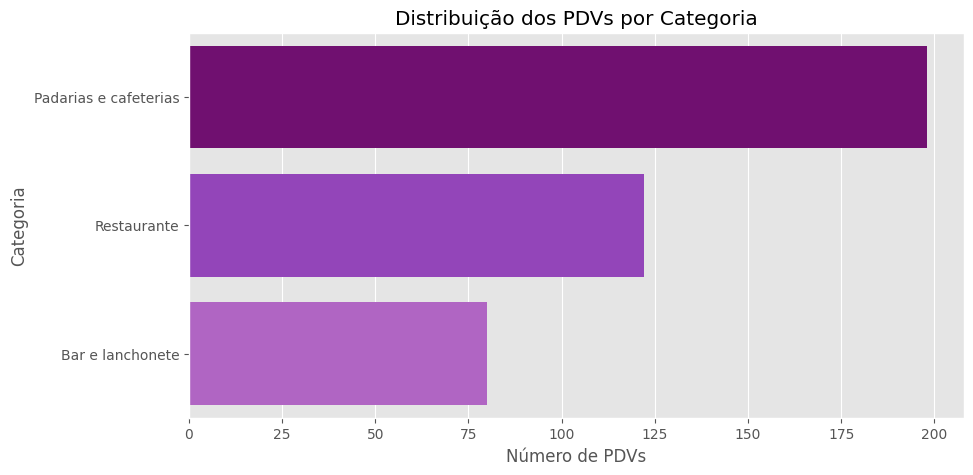

In [113]:
# Configuração do estilo
plt.style.use("ggplot")

#Fazer contagem de PDVs por categoria
categoria_counts = df_final["Categoria"].value_counts()

#Criar o gráfico de barras para categorias
plt.figure(figsize=(10, 5))
sns.barplot(x=categoria_counts.values, y=categoria_counts.index, palette=["#800080", "#9932CC", "#BA55D3"])
plt.xlabel("Número de PDVs")
plt.ylabel("Categoria")
plt.title("Distribuição dos PDVs por Categoria")
plt.show()

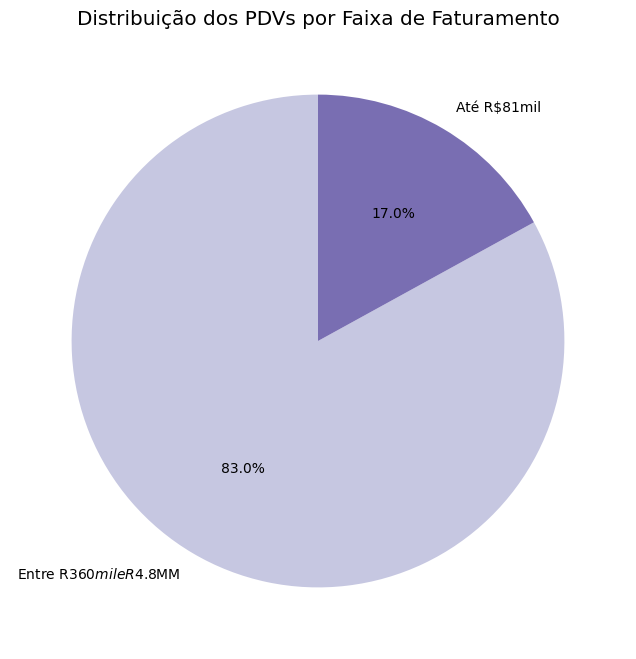

In [116]:
# Criar a contagem de PDVs por faixa de faturamento
faturamento_counts = df_final["Faixa de Faturamento"].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(
    faturamento_counts.values,
    labels=faturamento_counts.index,
    autopct="%1.1f%%",  # Exibir porcentagens no gráfico
    startangle=90,      # Começar o gráfico a partir de 90 graus
    colors=sns.color_palette("Purples", len(faturamento_counts))  # Paleta de cores
)
plt.title("Distribuição dos PDVs por Faixa de Faturamento")
plt.show()


<ipython-input-119-1678b788d47d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probabilidade_counts.values, y=probabilidade_counts.index, palette="magma")


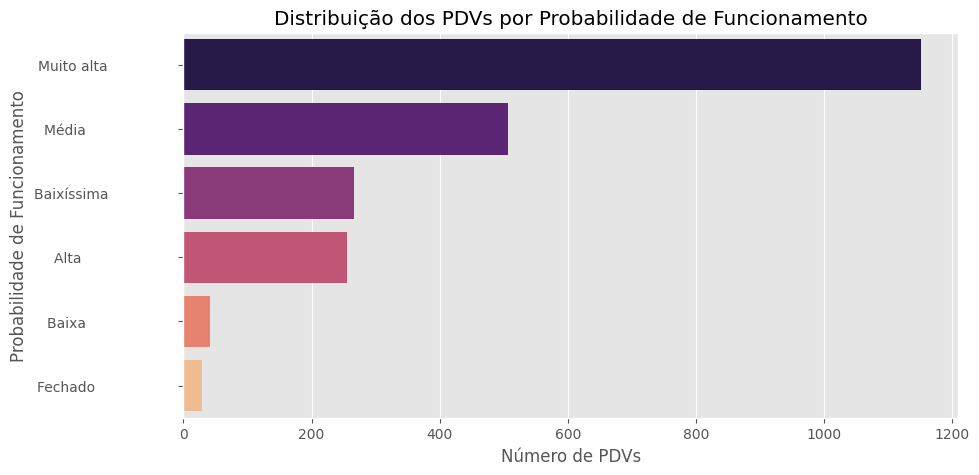

In [119]:
#Criar a contagem de PDVs por probabilidade de funcionamento no df original

probabilidade_counts = df["Probabilidade de Funcionamento"].value_counts()

#criar o gráfico de barras para probabilidade de funcionamento
plt.figure(figsize=(10, 5))
sns.barplot(x=probabilidade_counts.values, y=probabilidade_counts.index, palette="magma")
plt.xlabel("Número de PDVs")
plt.ylabel("Probabilidade de Funcionamento")
plt.title("Distribuição dos PDVs por Probabilidade de Funcionamento")
plt.show()

<ipython-input-120-8d904559b547>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probabilidade_counts.values, y=probabilidade_counts.index, palette="magma")


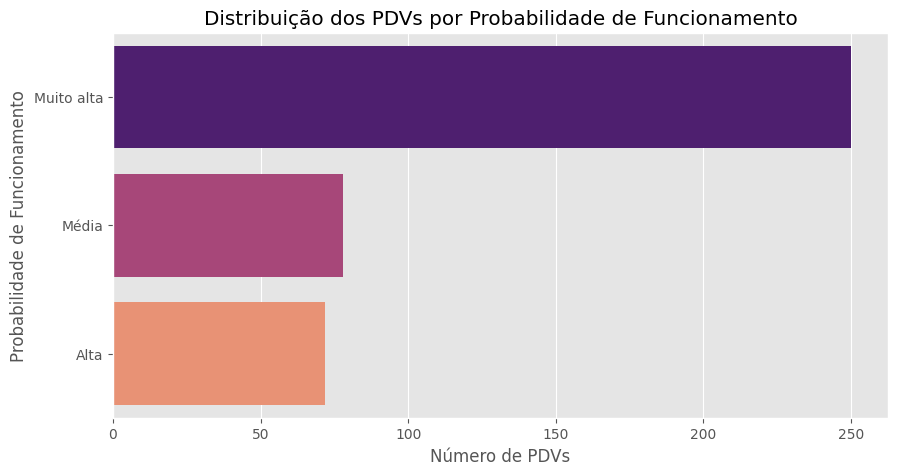

In [120]:
#Criar a contagem de PDVs por probabilidade de funcionamento no df apos filtragem e modelagem

probabilidade_counts = df_final["Probabilidade de Funcionamento"].value_counts()

#criar o gráfico de barras para probabilidade de funcionamento
plt.figure(figsize=(10, 5))
sns.barplot(x=probabilidade_counts.values, y=probabilidade_counts.index, palette="magma")
plt.xlabel("Número de PDVs")
plt.ylabel("Probabilidade de Funcionamento")
plt.title("Distribuição dos PDVs por Probabilidade de Funcionamento")
plt.show()